# Introduction

As displayed by the EDA per https://www.kaggle.com/gvyshnya/using-autoviz-to-build-a-comprehensive-eda , *cont2* and *cont14* seem to have a nice separation of values into relatively contained clusters vs. the values of *target* in the training set. It leads to the hypothesis on a statiscially meaningful clustering of the observations in the training and testing sets for this competition within the 2-dimentional affinity space of *cont2*X*cont14* 

*Notes*: 
- we are going to use KMeans clustering and Euclidian distance metric in *cont2*X*cont14* space to find the optimal clustering break-down
- there had been experiments with density clustering approach (namely, with *DBSCAN* method) but they did not work well for this dataset

# Preparation Activities

First of all, we are going to do a few usual preparation steps

- import the packages we need to work with in the course of the current analytical effort
- read the competion data in memory for future manipulations

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple, List, Dict

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline


# read data
in_kaggle = False


def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str]:
    train_path = ''
    test_path = ''
    sample_submission_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/tabular-playground-series-jan-2021/train.csv'
        test_path = '../input/tabular-playground-series-jan-2021/test.csv'
        sample_submission_path = '../input/tabular-playground-series-jan-2021/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train.csv'
        test_path = 'data/test.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, test_path, sample_submission_path

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# main flow
start_time = dt.datetime.now()
print("Started at ", start_time)

Started at  2021-01-15 22:10:49.658708


In [4]:
%%time
# get the training set and labels
train_set_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

df_train = pd.read_csv(train_set_path)
df_test = pd.read_csv(test_set_path)

subm = pd.read_csv(sample_subm_path)

# list of feature columns
feature_list = [col for col in df_train.columns if col.startswith('cont')]

Wall time: 1.4 s


Before moving on with the clustering experiments, we will check the basic info about our training dataset (records count, data types of variables, % of missing values etc.)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


Now, we are ready to create a subset of the training set to use in the clustering experiments

In [6]:
%%time
# Let's cluster the observations 

clustering_cols = ['cont2', 'cont14']

# subset of training set for the clustering experiment
X = df_train.filter(clustering_cols, axis=1)
#X = StandardScaler().fit_transform(X)

display(X.head())

,cont2,cont14
0,0.811300,0.305411
1,0.621104,0.369484
2,0.227436,0.303047
3,0.160155,0.279528
4,0.421235,0.435772


Wall time: 16 ms


Reducing the clustering feature space to 2 will allow for more relevant utilization of Euclidian distance-based clustering algorithms (like KMeans clustering we are going to utilize below).

However, the weak side of such algorithms is a certain voluntarism of a researcher in specifying the number of target clusters to be calculated by the analytical software before the actual analysis started. Thus the final clustering composition is very sensitive to the decision on the number of clusters to calculate (and thus the real analytical edge of the clustering composition could be less then useful).

To mitigate such a risk, we are going to put some data-driven ground into selection of a number of clusters to calculate for our current KMeans clustering experiment, using so called 'silhouette analysis' (as explained in https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

For n_clusters = 6 The average silhouette_score is : 0.4320940089083886
For n_clusters = 7 The average silhouette_score is : 0.40229302763073344
For n_clusters = 8 The average silhouette_score is : 0.39369069966804976
For n_clusters = 9 The average silhouette_score is : 0.3866720937290952
For n_clusters = 10 The average silhouette_score is : 0.388683610771474
For n_clusters = 11 The average silhouette_score is : 0.3942310263096754
For n_clusters = 12 The average silhouette_score is : 0.40816346970767087


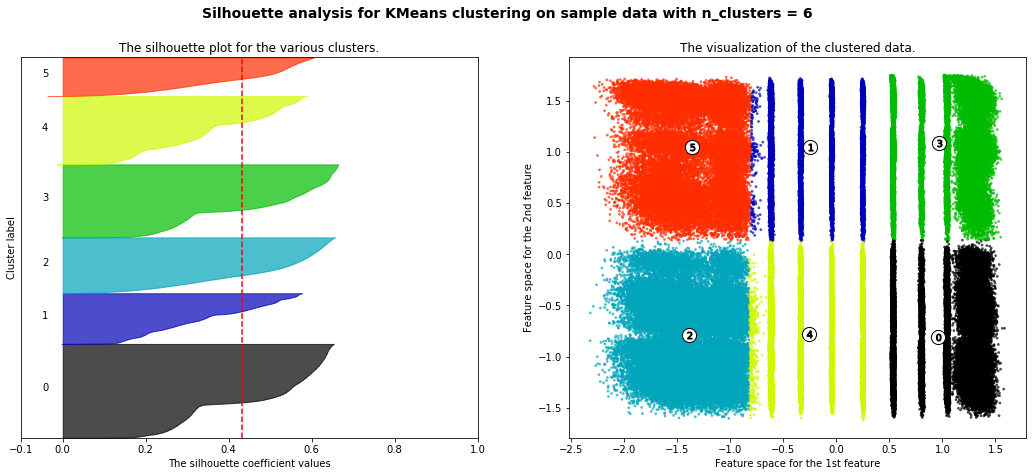

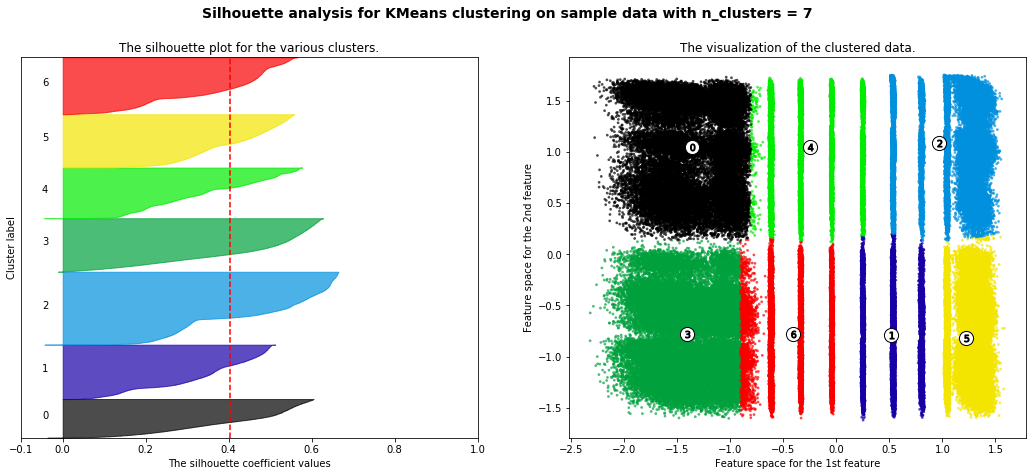

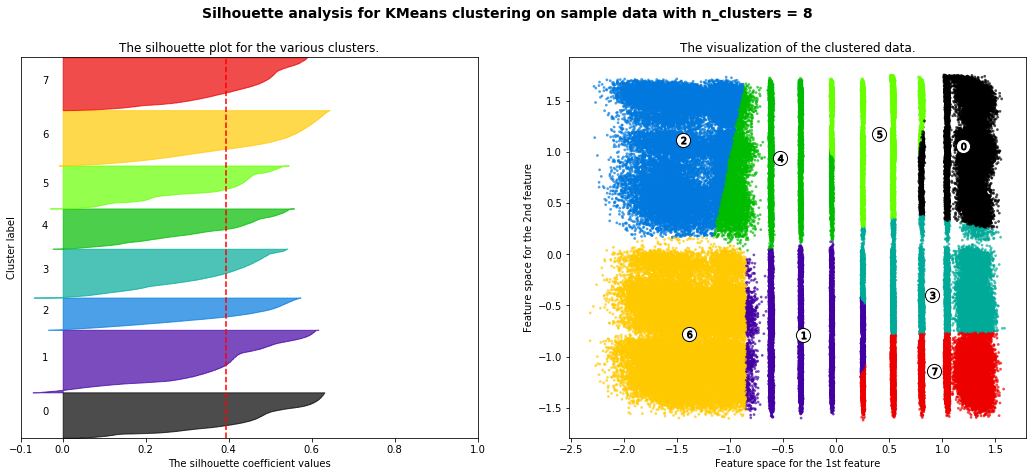

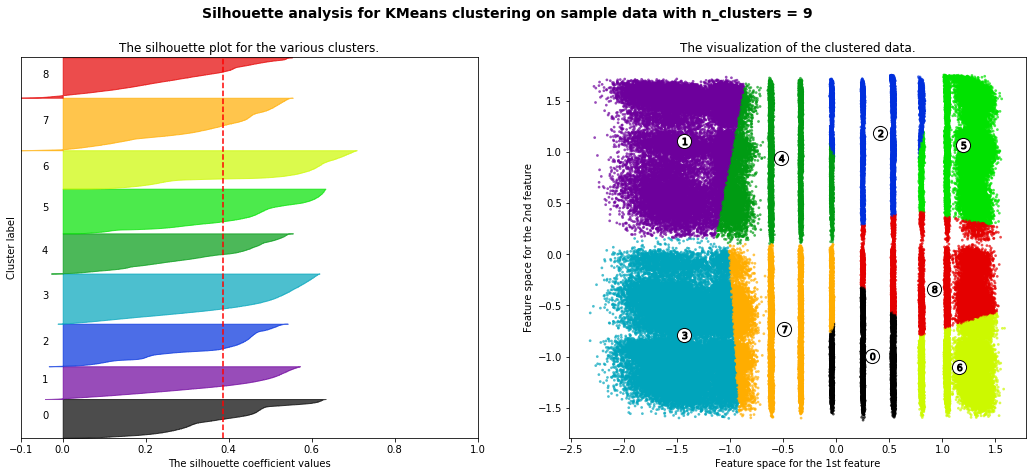

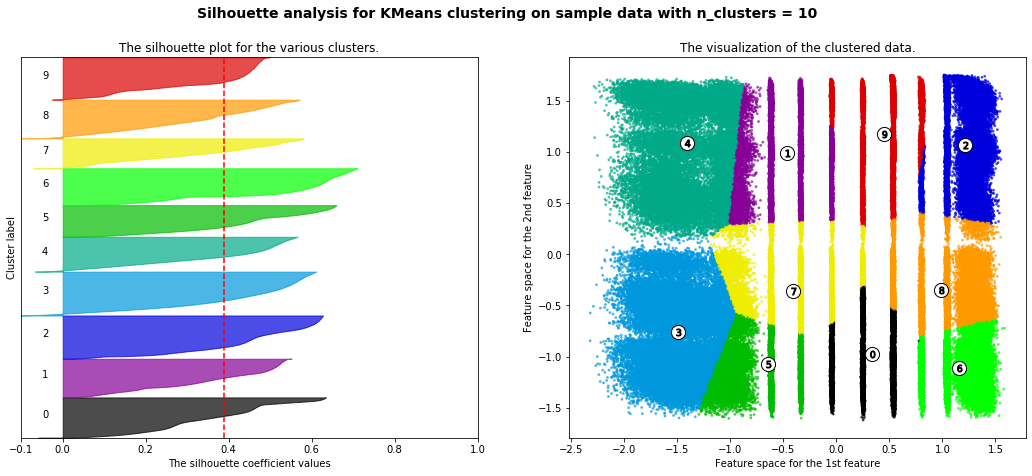

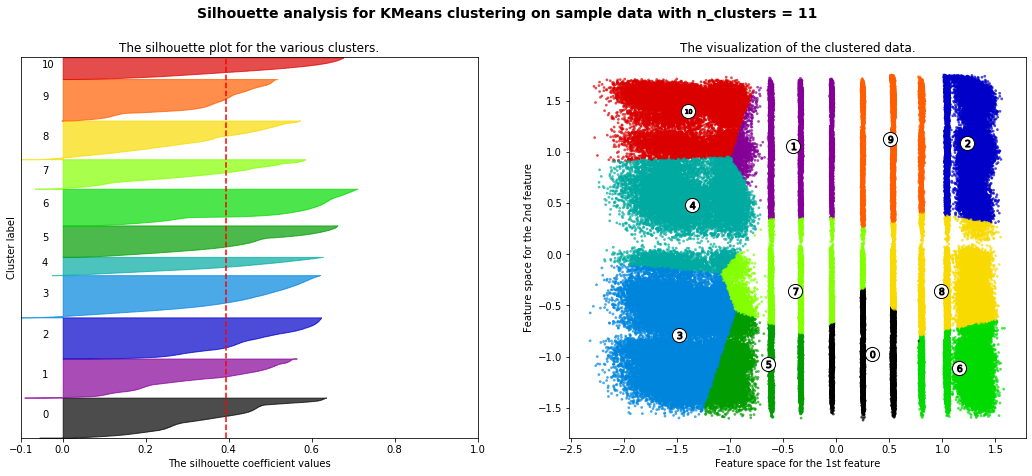

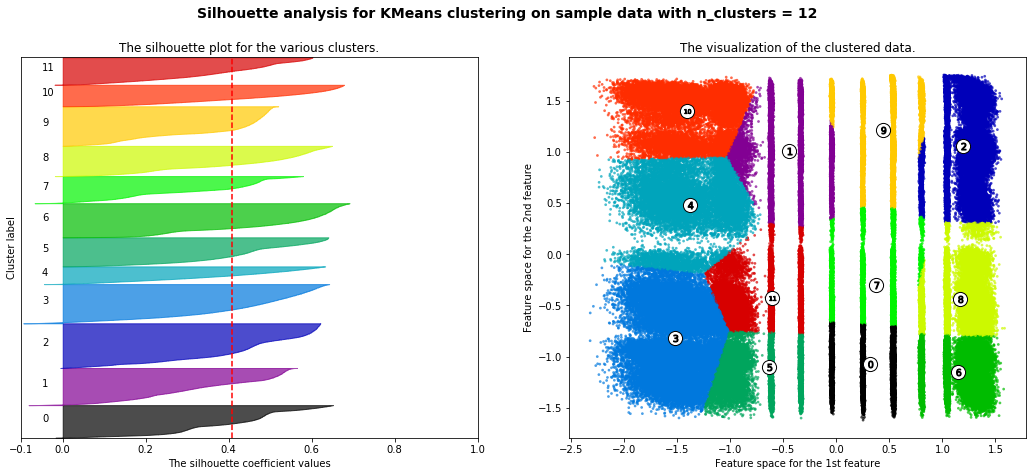

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



X = StandardScaler().fit_transform(X)

range_n_clusters = [6, 7, 8, 9, 10, 11, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

From reviewing the charts above, it looks like clustering with 6 clusters seems to be the best one in terms of their geometry and the points spread.

Now we are ready to proceed with the actual clustering the observations in the training and test sets, using KMeans clustering by 6 clusters.

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

clusters = kmeans.predict(X)
centroids = kmeans.cluster_centers_

df_train['cluster'] = clusters

# subset of training set for the clustering experiment
X_test = df_test.filter(clustering_cols, axis=1)
X_test = StandardScaler().fit_transform(X_test)

clusters_test = kmeans.predict(X_test)
df_test['cluster'] = clusters_test

# drop id column
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

df_train.groupby('cluster').mean().reset_index()

,cluster,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,0,0.495140,0.438702,0.514812,0.525541,0.487544,0.512612,0.477907,0.506941,0.444871,0.506775,0.469030,0.494020,0.542496,0.340514,7.932642
1,1,0.502215,0.718046,0.575824,0.510903,0.543394,0.549356,0.506773,0.558444,0.463182,0.538038,0.520140,0.538273,0.578949,0.729946,7.945672
2,2,0.482671,0.715955,0.594864,0.502437,0.528906,0.512896,0.509438,0.523834,0.440461,0.518155,0.502384,0.513473,0.531678,0.335925,7.929326
3,3,0.520013,0.441908,0.496058,0.542975,0.491956,0.543190,0.477408,0.543293,0.475348,0.525905,0.479052,0.513519,0.581961,0.721065,7.934489
4,4,0.534980,0.182507,0.434774,0.498330,0.454543,0.524198,0.478893,0.490066,0.473197,0.519505,0.462523,0.491073,0.537732,0.340464,7.821565
5,5,0.537219,0.187257,0.412138,0.528724,0.466088,0.522496,0.444400,0.524670,0.487472,0.511997,0.434477,0.468500,0.562728,0.722392,7.809005


As we can see from the feature variable mean variability across the clusters calculated on the training set, the clusters we calculated are statistically significant and really provide a meaningful grouping of the records of the training set.

Let's count the number of records in each cluster of the training set.

In [30]:
df_count = df_train.filter(['cluster', 'cont1'], axis=1)
df_count.groupby('cluster').count().reset_index()

,cluster,cont1
0,0,53820
1,1,57566
2,2,74021
3,3,39971
4,4,44056
5,5,30566


Now, we are going to check if the clustering calculated above is applicable to the testing set in the equally good manner.

In [13]:
df_test.groupby('cluster').mean().reset_index()

,cluster,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,250352.072043,0.519647,0.441442,0.494999,0.542671,0.493453,0.542349,0.476074,0.540827,0.475676,0.525611,0.477980,0.512288,0.580468,0.720961
1,1,248806.284077,0.482119,0.715717,0.596617,0.499131,0.528322,0.514731,0.511576,0.522804,0.439887,0.517759,0.503727,0.514158,0.531764,0.335963
2,2,249968.749923,0.495525,0.438512,0.513877,0.523047,0.488033,0.511528,0.476870,0.506465,0.444201,0.505255,0.467618,0.492765,0.542616,0.339280
3,3,252070.519424,0.503010,0.718288,0.575088,0.514447,0.543030,0.549400,0.505482,0.560021,0.463509,0.538256,0.519914,0.536483,0.580174,0.729621
4,4,249940.333268,0.540715,0.187483,0.408705,0.529263,0.467580,0.525754,0.443937,0.528060,0.491994,0.515717,0.436990,0.470992,0.570610,0.722965
5,5,250872.002940,0.534937,0.183349,0.435645,0.496192,0.454711,0.524370,0.478590,0.491193,0.474054,0.519233,0.463398,0.492568,0.538505,0.340715


As we can see from the feature variable mean variability across the clusters calculated on the testing set, the clusters are also statistically significant.

Let's count the number of records in each cluster of the testing set.

In [31]:
df_count = df_test.filter(['cluster', 'cont1'], axis=1)
df_count.groupby('cluster').count().reset_index()

,cluster,cont1
0,0,35861
1,1,38097
2,2,49646
3,3,26738
4,4,29264
5,5,20394


# References

You can find more theory on the methods/techniques used in this experiments per the links below

- Selecting the number of clusters with silhouette analysis on KMeans clustering - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
- Mukesh Chaudhary, Silhouette Analysis in K-means Clustering - https://medium.com/@cmukesh8688/silhouette-analysis-in-k-means-clustering-cefa9a7ad111

In [8]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

We are done. That is all, folks!
Finished at  2021-01-16 02:39:14.324276
Elapsed time:  4:28:24.665568
